# Working with the 6-hourly Global Drifter Program (GDP) data

In this Notebook, we use the [6-hourly data](https://www.aoml.noaa.gov/phod/gdp/interpolated/data/all.php) from the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/global-drifter-program/) to illustrate the steps necessary to process a Lagrangian dataset into a `RaggedArray` class object. This object can subsequently be converted to `xarray.Dataset` or `awkward.Array` instances for analysis. We also show how the *RaggedArray* object can also be written into files for archival.

## Import the `RaggedArray` class

In [1]:
from clouddrift import RaggedArray

## Dataset-specific functions

The `gdp6h.py` module (inside `clouddrift.adapters`) contains a number of specific functions for the current GDP 6-hourly files, including:

- `gdp6h.preprocess`: Preprocess and return an `xarray.Dataset` for a specific trajectory. 
- `gdp6h.download`: Download NetCDF files from the GDP FTP server.
- `gdp6h.rowsize [Optional]`: Return the dimension of a specific trajectory to speed up the preprocessing.

In [2]:
import sys

sys.path.append("../")
from clouddrift.adapters import gdp6h

## Download the GDP data

The `gdp6h.download` function will store the raw dataset into the `data/raw/gdp-6hourly/` folder (specified in the `gdp6h.py` module). By default `download()` will download the GPD dataset available on the [FTP/HTTPS repository](https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/)).

In [3]:
help(gdp6h.download)

Help on function download in module clouddrift.adapters.gdp6h:

download(drifter_ids: list = None, n_random_id: int = None, url: str = 'https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/')
    Download individual NetCDF files from the AOML server.
    
    Parameters
    ----------
    drifter_ids : list
        List of drifter to retrieve (Default: all)
    n_random_id : int
        Randomly select n_random_id drifter IDs to download (Default: None)
    url : str
        URL from which to download the data (Default: GDP_DATA_URL). Alternatively, it can be GDP_DATA_URL_EXPERIMENTAL.
    
    Returns
    -------
    out : list
        List of retrived drifters



With this function, it is also possible to retrieve a subset from a `drifter_ids` list or specified an integer `n_random_id` to randomly retrieve `n` trajectory. If both arguments are given, the function downloads `n_random_id` out of the list `drifter_ids`. The function returns the list of `drifters_ids` that was downloaded, and can be passed to create the ragged array.

In [4]:
drifter_ids = gdp6h.download(n_random_id=100)

In [5]:
drifter_ids[:5]

array([8707920, 7711139, 8811153, 7711566, 7711665])

## Create the `RaggedArray` instance

Once the data are downloaded, the *RaggedArray* object can be created and archived as a NetCDF file or a parquet file. In addition, the ragged array can be converted to an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) or an [Awkward Array](https://awkward-array.readthedocs.io/en/stable/_auto/ak.Array.html) in order to conduct analyses.

Before we do that, we must first define the dataset-specific coordinates, data, and metadata information.

In [6]:
coords = [
    "ids",
    "time",
]
data = [
    "lon",
    "lon360",
    "lat",
    "ve",
    "vn",
    "temp",
    "err_lat",
    "err_lon",
    "err_temp",
    "drogue_status",
]
metadata = [
    "ID",
    "rowsize",
    "WMO",
    "expno",
    "deploy_date",
    "deploy_lat",
    "deploy_lon",
    "end_date",
    "end_lat",
    "end_lon",
    "start_date",
    "start_lat",
    "start_lon",
    "drogue_lost_date",
    "typedeath",
    "typebuoy",
    "DeployingShip",
    "DeploymentStatus",
    "BuoyTypeManufacturer",
    "BuoyTypeSensorArray",
    "CurrentProgram",
    "PurchaserFunding",
    "SensorUpgrade",
    "Transmissions",
    "DeployingCountry",
    "DeploymentComments",
    "ManufactureYear",
    "ManufactureMonth",
    "ManufactureSensorType",
    "ManufactureVoltage",
    "FloatDiameter",
    "SubsfcFloatPresence",
    "DrogueType",
    "DrogueLength",
    "DrogueBallast",
    "DragAreaAboveDrogue",
    "DragAreaOfDrogue",
    "DragAreaRatio",
    "DrogueCenterDepth",
    "DrogueDetectSensor",
]

Now we can pass this information together with the dataset-specific pre-processing function to process the GDP dataset from its own format into a `RaggedArray` instance:

In [7]:
# this is only required for the gdp preprocess function
gdp6h_custom_args = {
    "tmp_path": gdp6h.GDP_TMP_PATH,
    "filename_pattern": "drifter_{id}.nc",
}

ra = RaggedArray.from_files(
    drifter_ids, gdp6h.preprocess, coords, metadata, data, **gdp6h_custom_args
)

Filling the Ragged Array: 100%|███████████████| 100/100 [00:01<00:00, 53.12it/s]


## Export to data files

Currently, exporting the `RaggedArray` instance to NetCDF and Apache Parquet file formats is supported.

### NetCDF

In [8]:
ra.to_netcdf("../data/process/gdp_6h.nc")

### Apache Parquet

In [9]:
ra.to_parquet("../data/process/gdp_6h.parquet")

## Import from data files

As with exporting to files, we can import a `RaggedArray` instance from a NetCDF or Apache Parquet files. 

### NetCDF

In [10]:
ra = RaggedArray.from_netcdf("../data/process/gdp_6h.nc")

### Apache Parquet

In [11]:
ra = RaggedArray.from_parquet("../data/process/gdp_6h.parquet")

## Converting to data structures for analysis

Typically, you would not do your data analysis directly on a `RaggedArray` instance.
Instead, you first convert it to a data structure that is geared for data analysis and exploratory science.
Currently, the library supports Xarray Dataset and Awkward Array structures.

### Xarray Dataset

In [12]:
ds = ra.to_xarray()

Now we have our GDP dataset as an Xarray Dataset while also being optimized for memory.
Let's see what's inside:

In [13]:
ds

<xarray.Dataset>
Dimensions:                (traj: 100, obs: 164263)
Coordinates:
    time                   (obs) float64 5.484e+08 5.484e+08 ... 1.668e+09
    lon                    (obs) float64 -124.2 -124.2 -124.2 ... 160.3 160.4
    lat                    (obs) float64 37.87 37.83 37.77 ... 41.82 41.84 41.91
    ids                    (obs) int64 8707920 8707920 ... 300534061381210
Dimensions without coordinates: traj, obs
Data variables: (12/48)
    ID                     (traj) int64 8707920 7711139 ... 300534061381210
    rowsize                (traj) int32 118 768 1295 864 ... 1391 246 597 164
    WMO                    (traj) int32 0 5100822 3200542 ... 2101835 2101841
    expno                  (traj) int32 5425 9129 9129 ... 21421 31412 31412
    deploy_date            (traj) float64 5.484e+08 6.036e+08 ... 1.664e+09
    deploy_lat             (traj) float64 37.92 8.028 -1.09 ... -18.0 51.1 42.71
    ...                     ...
    vn                     (obs) float64 nan -0.2752 -0.3636 ... 0.2192 nan
    temp                   (obs) float64 11.71 11.9 12.31 ... 17.24 17.13 17.02
    err_lat                (obs) float64 0.001785 0.00196 ... 0.001521 0.001634
    err_lon                (obs) float64 0.002347 0.002507 ... 0.002074 0.002412
    err_temp               (obs) float64 0.06759 0.06006 ... 0.04103 0.05986
    drogue_status          (obs) bool True True True True ... True True True
Attributes: (12/16)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           version 2.00. Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2023-04-18T23:22:30.469270
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global Dr...
    summary:           Global Drifter Program six-hourly data
    doi:               10.25921/7ntx-z961


Time, longitude, and latitude arrays are 1-dimensional and are effectively a concatenated list of drifter trajectories. The `ids` array can be used to mask (subset) a specific drifter. Let's make a quick trajectory map by looping over all the trajectories and plotting them one by one.

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '100 random trajectories from the 6-hourly GDP dataset')

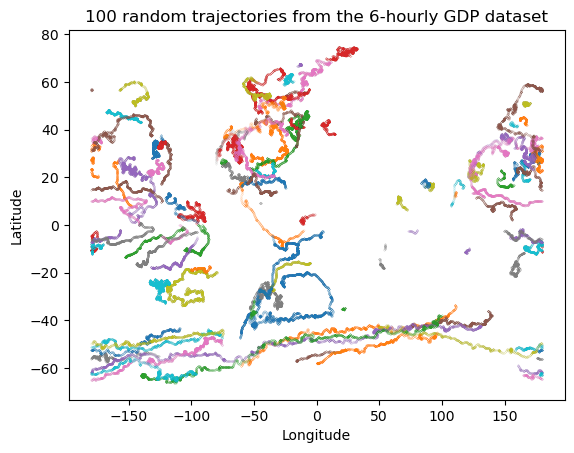

In [15]:
for drifter_id in drifter_ids:
    this_drifter = ds.ids == drifter_id
    plt.plot(
        ds.lon[this_drifter], ds.lat[this_drifter], linestyle="", marker=".", ms=0.1
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the 6-hourly GDP dataset")

You may find that the method above is relatively slow to plot for a large number of trajectories. Alternatively, we can construct an index variable that indexes the beginning of each trajectory in the ragged arrays (with index `0` for the first trajectory). We first need to import the `numpy` package to conduct some mathematical operations to calculate that index variable.

In [16]:
import numpy as np

In [17]:
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

Text(0.5, 1.0, '100 random trajectories from the 6-hourly GDP dataset')

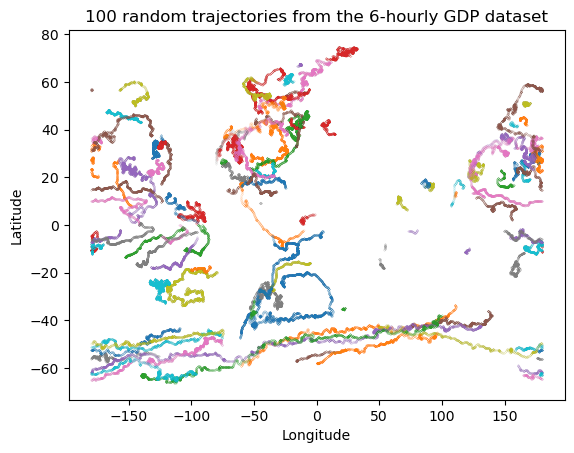

In [18]:
for j in range(len(drifter_ids)):
    plt.plot(
        ds.lon[slice(traj_idx[j], traj_idx[j + 1])],
        ds.lat[slice(traj_idx[j], traj_idx[j + 1])],
        linestyle="",
        marker=".",
        ms=0.1,
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the 6-hourly GDP dataset")

### Awkward Array

In [19]:
ds = ra.to_awkward()

With an awkward array, there is no need to define an index variable as for an xarray Dataset:

Text(0.5, 1.0, '100 random trajectories from a GDP dataset')

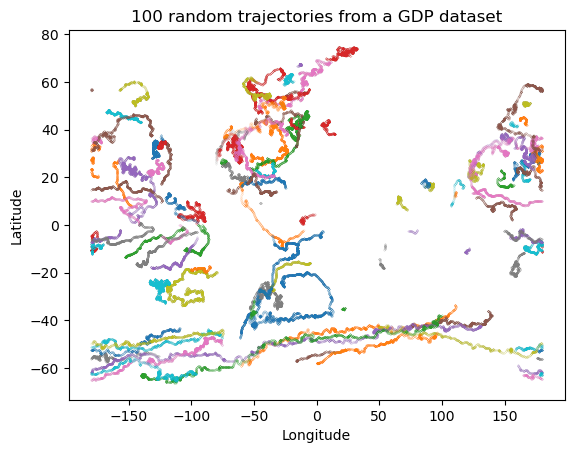

In [20]:
for n in range(len(drifter_ids)):
    plt.plot(ds.obs["lon"][n], ds.obs["lat"][n], linestyle="", marker=".", ms=0.1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from a GDP dataset")